![](itd.png)

    
# Análisis de Datos Masivos
## Verificación de velocidades de Internet
## Nombre del docente
### José Gabriel Rodriguez Rivas
## Nombre del alumno
### Calos Alberto Carrete Gómez

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
%matplotlib inline
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

### Parte 1: Determinar si la velocidad de Internet proporcionada cumple con la establecida en el contrato del proveedor

#### Paso 1: Importación y limpieza de datos



In [2]:
df = pd.read_csv('rpi_data_processed.csv')
df.head()

,Date,Time,Ping (ms),Download (Mbit/s),Upload (Mbit/s)
0,2016-11-24,13:36:25,26.992,91.80,14.31
1,2016-11-24,13:36:55,24.532,88.19,14.12
2,2016-11-24,13:37:25,20.225,59.86,14.11
3,2016-11-24,13:37:57,19.332,91.81,14.22
4,2016-11-24,13:38:27,22.494,92.05,14.08


In [3]:
df.isnull().sum() #Se verifia si se encuentra un valor nulo o no

Date                 0
Time                 0
Ping (ms)            0
Download (Mbit/s)    0
Upload (Mbit/s)      0
dtype: int64

In [4]:
#Se convierten los valores de Ping y Download en Flotantes
df['Ping (ms)'] = df['Ping (ms)'].apply(lambda val: float(val))
df['Download (Mbit/s)'] = df['Download (Mbit/s)'].apply(lambda val: float(val))

#### Paso 2: Comprensión de la promesa

Generalmente, su proveedor no prometerá una velocidad de Internet mínima garantizada. Por lo general, deberá especificar sólo la velocidad máxima de Internet que se puede ofrecer en su ubicación. Esto genera la pregunta "¿Es mi conexión a Internet más rápida o más lentamente de lo prometido?” y evaluar la calidad de servicio se convierte en algo un poco complicado.

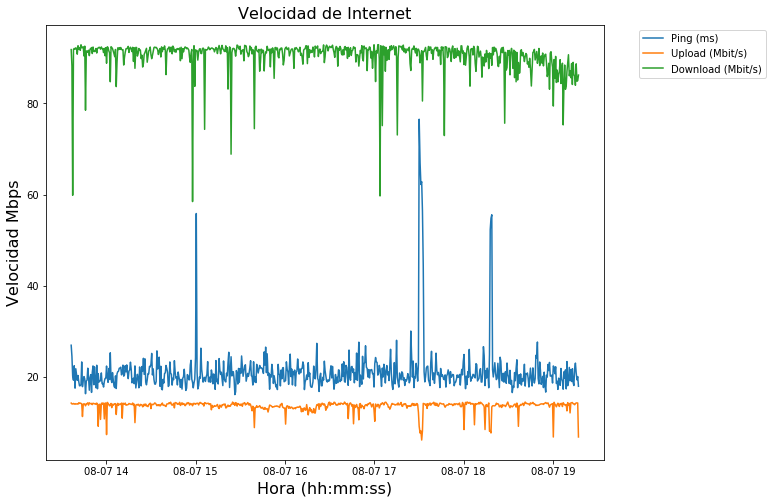

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
# Grafica
t = pd.to_datetime(df['Time'])
ax.plot(t, df['Ping (ms)'], label='Ping (ms)')
ax.plot(t, df['Upload (Mbit/s)'], label='Upload (Mbit/s)')
ax.plot(t, df['Download (Mbit/s)'], label='Download (Mbit/s)')

# Insert a legend outside of the main plot
ax.set_xlabel('Hora (hh:mm:ss)', size = 16)
ax.set_ylabel('Velocidad Mbps', size = 16)
ax.set_title('Velocidad de Internet', size = 16)
plt.legend(bbox_to_anchor=(1.3, 1.))
plt.show()

In [6]:
# Valores de velocidades considerados como aceptables
#Se utilizarón los datos que vienen como ejemplos en la práctica
acceptable_upload = 13 #Mbit/s
acceptable_download = 88 #Mbit/s
acceptable_ping = 20 #ms


#### Paso 3: Comparación con expectativas

Tiene un conjunto de datos limpio y ha especificado los valores aceptables. Esto significa que está listo para iniciar la mayor parte del análisis. Una buena estrategia es comenzar con tareas sencillas y avanzar gradualmente a métodos más avanzados.

a) Trace histogramas por velocidad de descarga, velocidad de carga y tiempo de ping. En cada uno de estos gráficos, utilice una línea vertical para indicar el valor que considera aceptable para cada medición.


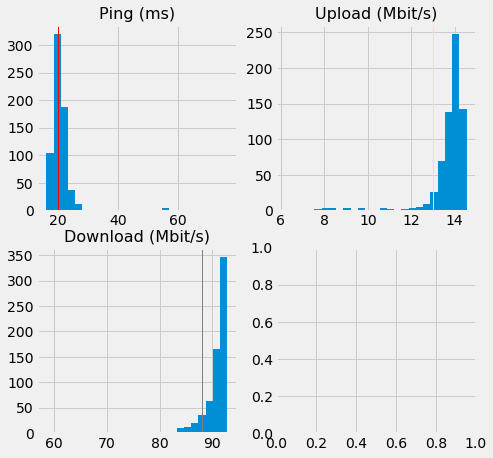

In [7]:
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(2,2,figsize=(7, 7))

    # Gráfica de la velocidad del ping
    ax[0][0].hist(df['Ping (ms)'], 25)
    # Gráfica del Ping Aceptable
    ax[0][0].axvline(acceptable_ping, color='red', linewidth=1)
    ax[0][0].set_title('Ping (ms)', fontsize=16)

    # Gráfica de la velocidad de subida
    ax[0][1].hist(df['Upload (Mbit/s)'], 25)
    # Gráfica de la velocidad de subida aceptable
    ax[0][1].axvline(acceptable_upload, color='yellow', linewidth=1)
    ax[0][1].set_title('Upload (Mbit/s)', fontsize=16)

    # Gráfica de la velocidad de descarga
    ax[1][0].hist(df['Download (Mbit/s)'], 25)
    #Gráfica de la velocidad de descarga aceptable
    ax[1][0].axvline(acceptable_download, color='gray', linewidth=1)
    ax[1][0].set_title('Download (Mbit/s)', fontsize=16)



b) Calcule el promedio y la desviación estándar de la velocidad de descarga, la velocidad de carga y el tiempo de ping, y calcule cuántas desviaciones estándar separan a los valores aceptables de los valores promedio.


In [8]:
means = df.mean()
stands = df.std()

quote_ping = (means['Ping (ms)'], stands['Ping (ms)'])
quote_download = (means['Download (Mbit/s)'], stands['Download (Mbit/s)'])
quote_upload = (means['Upload (Mbit/s)'], stands['Upload (Mbit/s)'])

# Se imprimen los resultados
print('Tiempo de Ping promedio: {} ± {} ms'.format(*quote_ping))
print ('Velocidad de descarga promedio: {} Mb/s'.format(*quote_download))
print ('Velocidad de subida promedio: {} Mb/s'.format(*quote_upload))
print("---------------------------------------")
print('Distancia entre la velocidad de Ping aceptable y : {:.2f} la desviación estandar'.format((quote_ping[0]-acceptable_ping)/quote_ping[1]))
print('Distancia entre la velocidad de Descarga aceptable y  {:.2f} la desviación estandar'.format((quote_download[0]-acceptable_download)/quote_download[1]))
print('Distancia entre la velocidad de Subida aceptable y  {:.2f} la desviación estandar'.format((quote_upload[0]-acceptable_upload)/quote_upload[1]))

Tiempo de Ping promedio: 21.113875000000007 ± 5.164907779028767 ms
Velocidad de descarga promedio: 90.45629464285713 Mb/s
Velocidad de subida promedio: 13.69681547619048 Mb/s
---------------------------------------
Distancia entre la velocidad de Ping aceptable y : 0.22 la desviación estandar
Distancia entre la velocidad de Descarga aceptable y  0.71 la desviación estandar
Distancia entre la velocidad de Subida aceptable y  0.64 la desviación estandar




C) Calcule el porcentaje de mediciones de velocidad de descarga que no son aceptables. Repita este cálculo para la velocidad de carga y ping.


In [9]:
print('{:.2f}% de las mediciones son inferiores a la velocidad de descarga aceptable.'.format(np.sum(df['Download (Mbit/s)']<acceptable_download)/float(len(df))*100))
print('{:.2f}% de las mediciones son inferiores a la velocidad de subida aceptable.'.format(np.sum(df['Upload (Mbit/s)']<acceptable_upload)/float(len(df))*100))
print('{:.2f}% de las mediciones son inferiores a la velocidad de ping aceptable.'.format(np.sum(df['Ping (ms)']<acceptable_ping)/float(len(df))*100))

10.86% de las mediciones son inferiores a la velocidad de descarga aceptable.
7.89% de las mediciones son inferiores a la velocidad de subida aceptable.
42.86% de las mediciones son inferiores a la velocidad de ping aceptable.




d) Busque el porcentaje de mediciones que no satisface sus criterios de servicio aceptable en las tres cantidades.


In [10]:
all_three = np.sum((df['Ping (ms)']<acceptable_ping) & (df['Download (Mbit/s)']<acceptable_download) & (df['Upload (Mbit/s)']<acceptable_upload))
print('{:.2f}% de las mediciones no son aceptables en los 3 casos.'.format(all_three/float(len(df))*100))


0.60% de las mediciones no son aceptables en los 3 casos.




e) Busque el porcentaje de mediciones que no satisface sus criterios de servicio aceptable en dos de las tres cantidades.


In [11]:
ping_upload = np.sum((df['Ping (ms)']<acceptable_ping) & (df['Upload (Mbit/s)']<acceptable_upload))
print('{:.2f}% de las mediciones no son aceptables para ping y subida.'.format(ping_upload/float(len(df))*100))

ping_download = np.sum((df['Ping (ms)']<acceptable_ping) & (df['Download (Mbit/s)']<acceptable_download))
print('{:.2f}% de las mediciones no son aceptables para ping y descarga.'.format(ping_download/float(len(df))*100))

upload_download = np.sum((df['Upload (Mbit/s)']<acceptable_upload) & (df['Download (Mbit/s)']<acceptable_download))
print('{:.2f}% de las mediciones no son aceptables para subida y descarga.'.format(upload_download/float(len(df))*100))

2.98% de las mediciones no son aceptables para ping y subida.
4.61% de las mediciones no son aceptables para ping y descarga.
1.34% de las mediciones no son aceptables para subida y descarga.
